# Generative Models
***

**MIPT, Autumn 2022, MSc course**


## Assignment 4

***


*Authored by Arip Asadulaev & Manh Lab*

*Adapted by Rostislav Korst*

***


### Метрики качества генерации:

IS

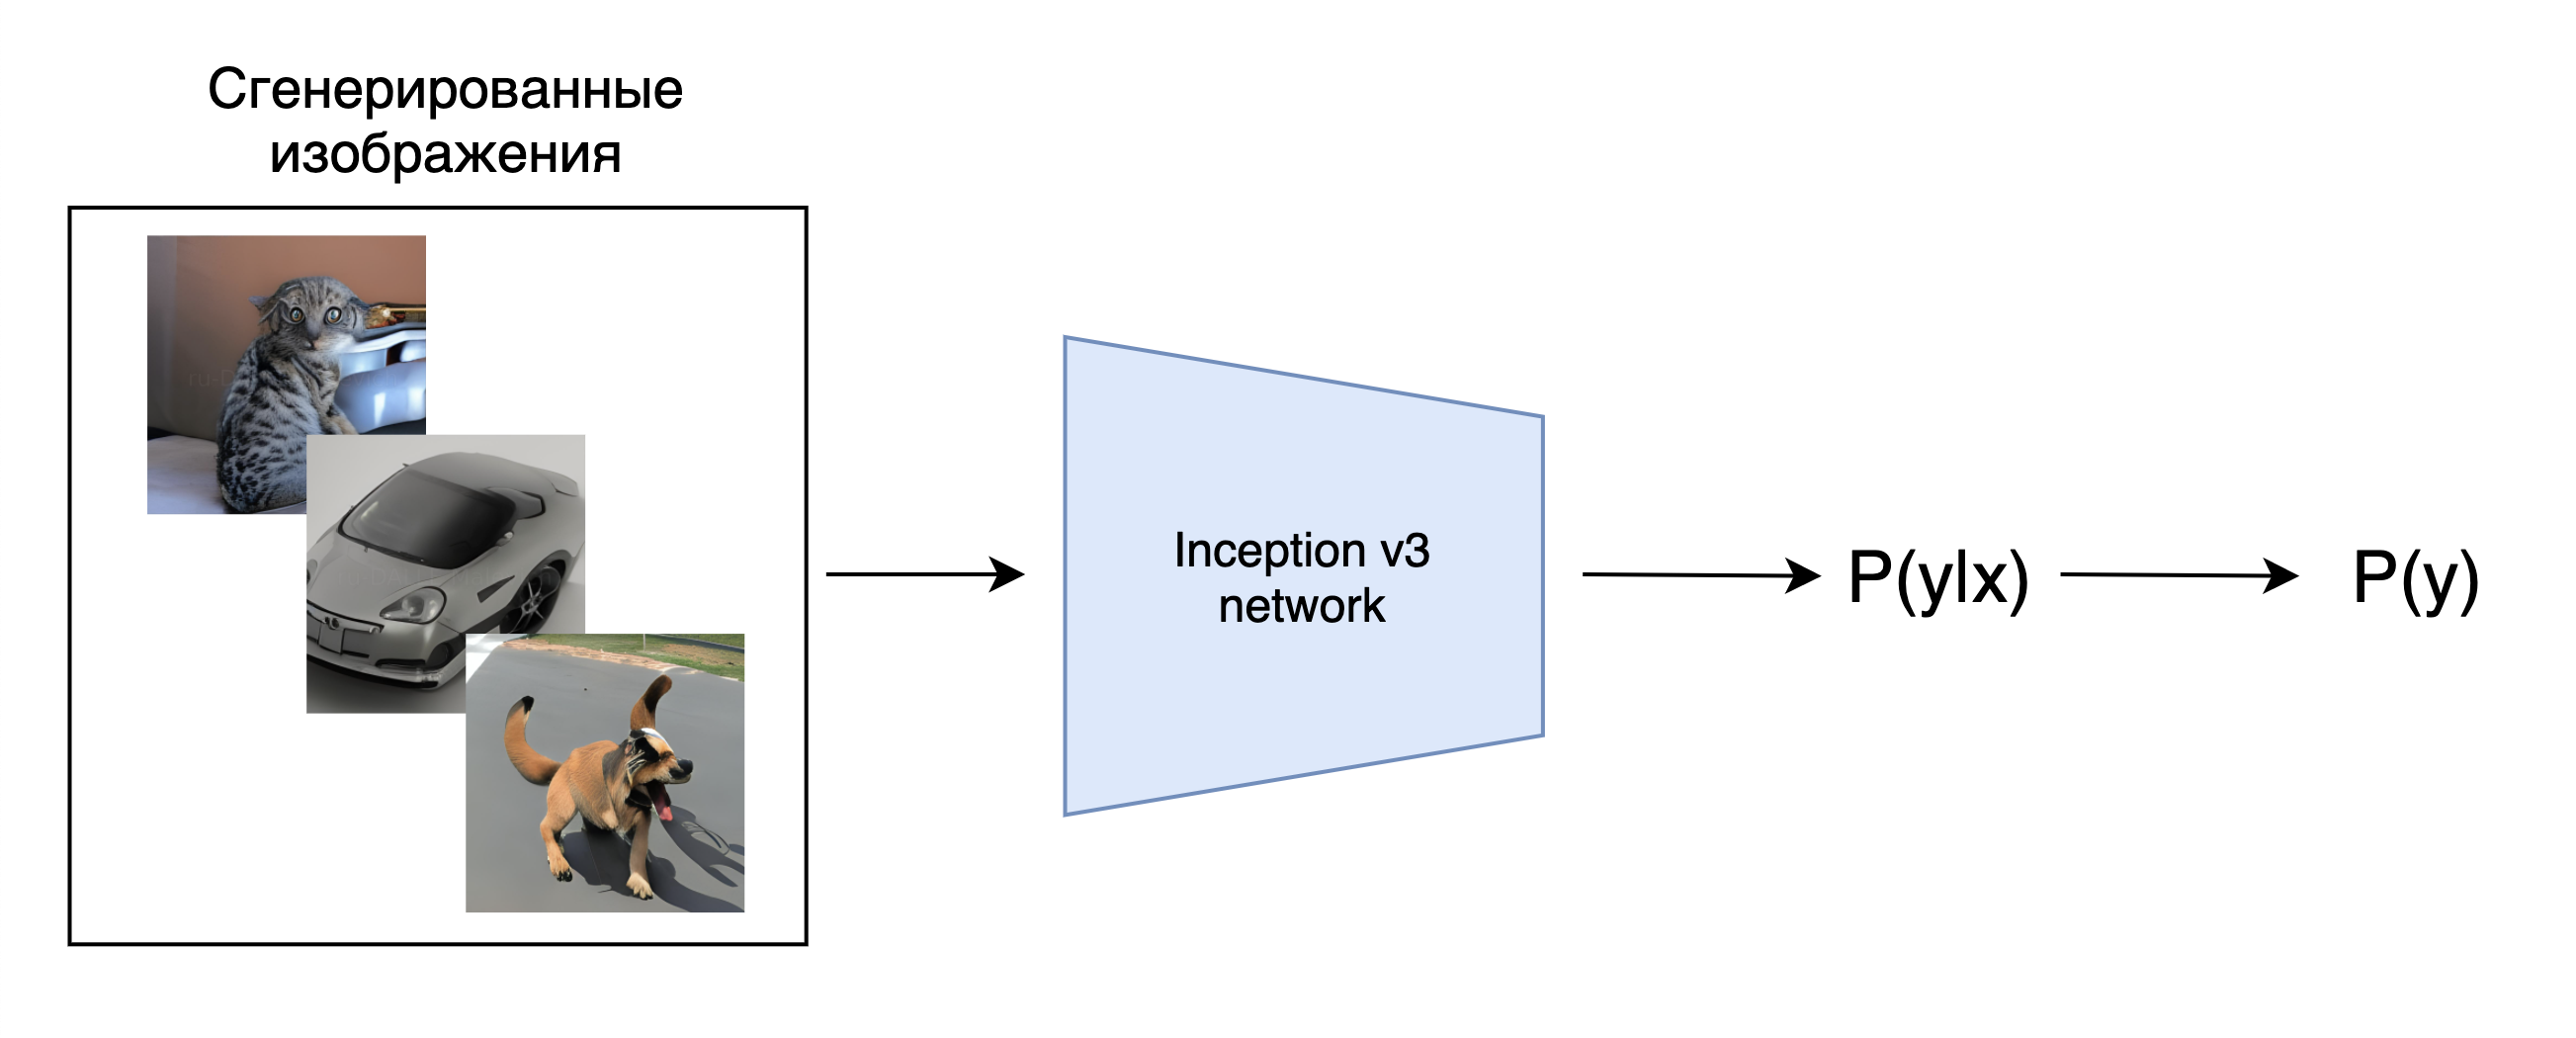

Для оценки метрики, называемой Inception score (IS), применяется классификатор Inception model, обученный на датасете ImageNet.

С помощью классификации сгенерированных изображений данной внешней моделью получается условное распределение лейблов от картинок $p(y|\mathbf{x})$. Сгенерированные картинки, похожие на что-то реальное из классов, которые есть в ImageNet, должны иметь распределение $p(y|x)$ с низкой энтропией:

\begin{equation}
    H(x) = - \sum_{i=1}^{n} p_i \log p_i 
\end{equation}

То есть модель должна быть уверена, что на картинке изображена, например, собака.

Однако также сгенерированные изображения должны быть разнообразны, то есть наша модель генерации должна генерировать и кошек, и собак, и машины, а не только один какой-то понравившийся ей класс. Поэтому энтропия маргинализованного по пространству картинок распределения должна быть высокой.

\begin{equation}
    p(y) = \int_X p(y|x) dx 
\end{equation}

Комбинируя эти два требования, получается метрика, которая меряет расстояние между двумя распределениями. Чем это расстояние больше, тем лучше. Метрика IS дается выражением:

\begin{equation}
    IS = exp \left( \mathbb{E}_{x \sim p_g} D_{KL}(p(y|x) \parallel p(y)) \right)
\end{equation}

где $D_{KL}$ - KL-дивергенция. $p_g$ - распределение сгенерированных изображений.

FID

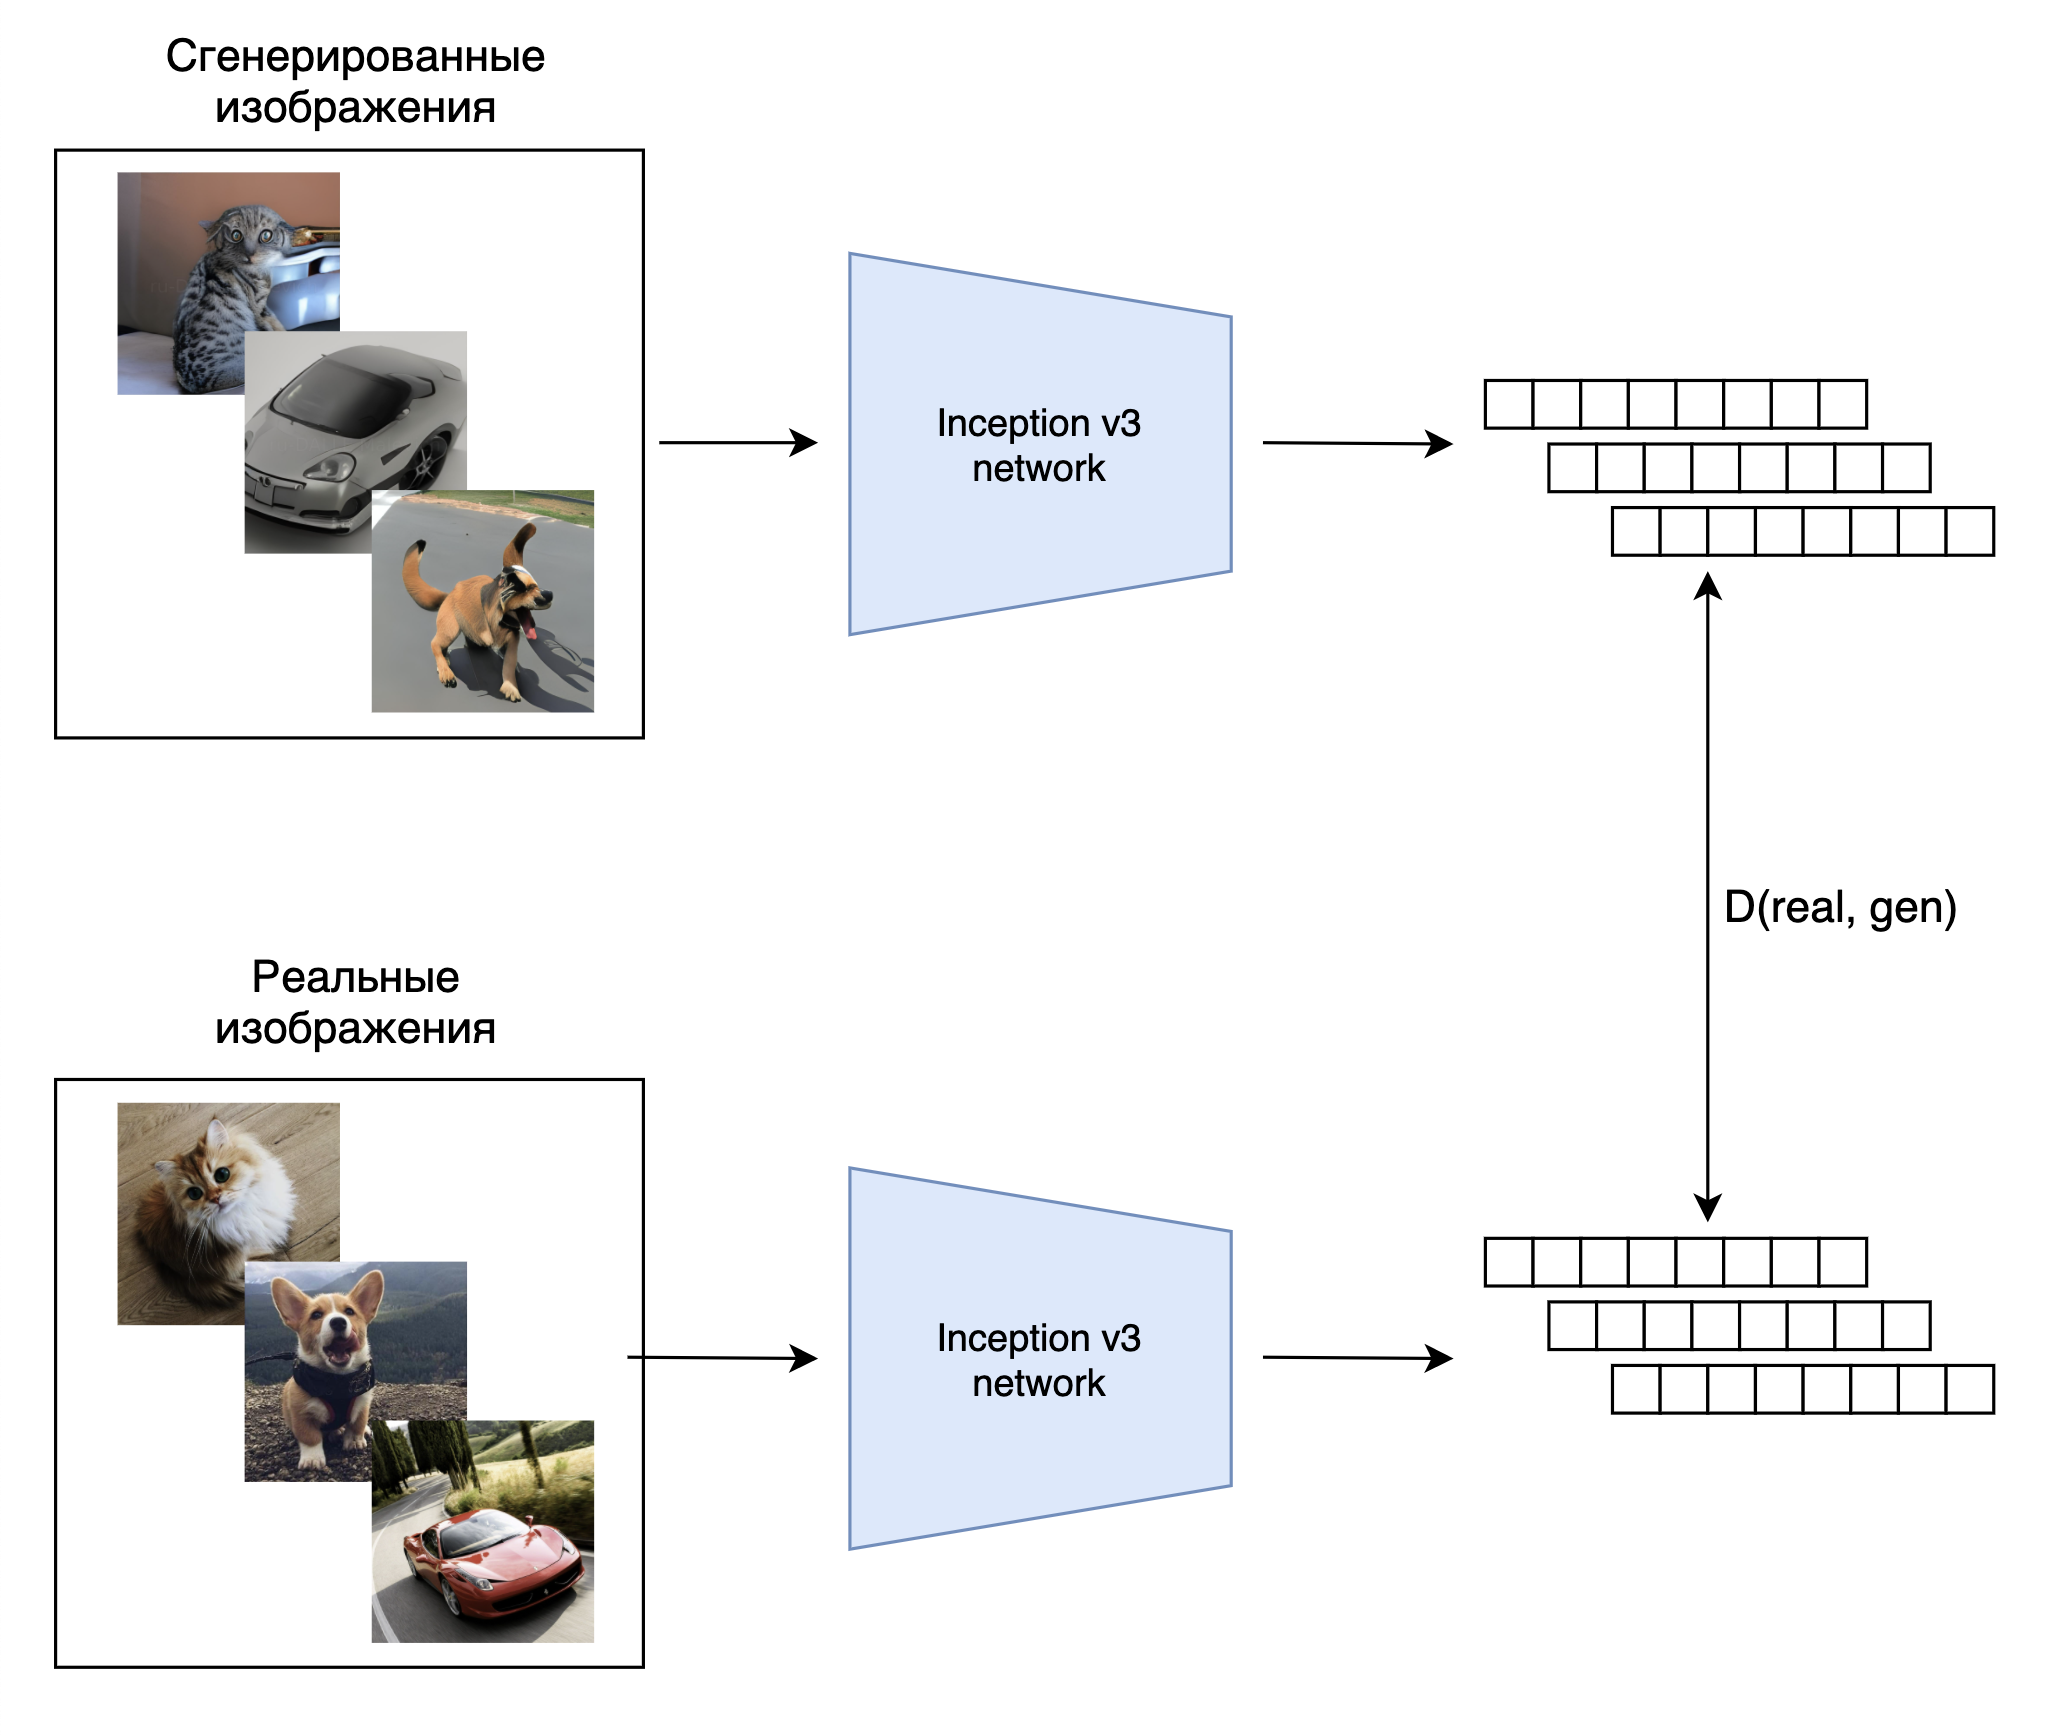

Минусом метрики IS является то, что она никак не учитывает распределение реальных данных для оценки качества сгенерированных изображений. Поэтому была предложена другая метрика Fréchet inception distance (FID).

Мотивация этой метрики состоит в том, чтобы сравнить распределения реальных и сгенерированных данных, или, другими словами, померить расстояние между двумя распределениями. Но измерения производятся не на самом распределении данных, а на некотором извлеченном из картинок представлении. Для этого каждое из сгенерированных изображений подается в модель Inception model (аналогично Inception Score), последний слой пуллинга (последний слой перед линейным преобразованием в логиты классификатора) которой выступает в качестве представления изображений. Inception v3 network, используемая для расчета обоих метрик, - это конкретная модель, поэтому можно сказать, что представление изображений в ней - это вектор длиной 2048. Представление получается также и для изображений исходного датасета. 


Распределения двух полученных представлений упрощенно рассматриваются как многомерные Гауссианы, расстояние между которыми можно померить с помощью Fréchet distance.

Для одномерного нормального распределения расстояние будет выглядеть следующим образом:

\begin{equation}
    d(X, Y) = (\mu_X - \mu_Y)^2 + (\sigma_X - \sigma_Y)^2 = (\mu_X - \mu_Y)^2 + (\sigma^2_X + \sigma^2_Y - 2\sigma_X \sigma_Y)
\end{equation}

Для многомерного нормального распределения формула расстояния следующая:

\begin{equation}
    d(X, Y) = \| \mathbf{\mu}_X - \mathbf{\mu}_Y \|^2 + Tr(\mathbf{\Sigma}_X + \mathbf{\Sigma}_Y - 2\sqrt{\mathbf{\Sigma}_X \mathbf{\Sigma}_Y})
\end{equation}

Соответственно, FID показывает расстояние между сгенерированными изображениями и исходным реальным датасетом, поэтому, чем меньше расстояние, тем сгенерированные изображения лучше.

### Задание:

В данном задании нужно будет 

* Обучить GAN на датасете CIFAR10, используя методы регуляризации: label smoothing, spectral normalization, подача шума на дискриминатор поверх сгенерированных и реальных данных.

* Замерить качество генерации изображений с помощью метрик IS и FID. Привести примеры генерации и таблицу с результатами обучения моделей без регуляризаций и с различными их комбинациями (хотя бы одной). Сравните метрики сгенерированных изображений с метриками исходного датасета.

Пример таблицы:



Model | IS $⇑$ | FID $⇓$ |
---------|------|-----------|
DCGAN | | 
Label Smoothing (LS) |  | 
Spectral Normalization (SN) |  | 
DCGAN + LS + SN | | 
CIFAR10 | 10.98 ± 0.22 | 3.1508


# Define parameters & Load Dataset 

In [ ]:
import torch 
import torch.nn as nn
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torchvision
from torch.utils.data import DataLoader
from torch.optim import Adam
from torchvision import transforms
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST, CIFAR10
from IPython.display import Image
from torchvision.utils import save_image, make_grid
from google.colab import drive
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import os
import pickle
import shutil
import pandas as pd
%matplotlib inline 
plt.style.use("ggplot")

class CFG:
    #        DCGAN   DCGAN1   DCGAN2   DCGAN3
    d_steps = 8    #   6    #   10   #   5
    g_steps = 10   #   10   #   10   #   4
    batch_size = 128
    num_epochs = 200
    workers = 2
    seed = 2021
    image_size = 64
    download = True
    dataroot = "/content/data"
    nc = 3  ## number of chanels
    ngf = 64  # Size of feature maps in generator
    nz = 100  # latent random input vector
    ndf = 64  # Size of feature maps in discriminator
    lr = 0.0001
    betas = (0.5, 0.999)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    sample_dir = "/content/images/"


if not os.path.exists(CFG.sample_dir):
    os.makedirs(CFG.sample_dir)

cifar_dataset = CIFAR10(
    root=CFG.dataroot,
    download=CFG.download,
    transform=transforms.Compose(
        [
            transforms.Resize([CFG.image_size, CFG.image_size]),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    ),
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting /content/data/cifar-10-python.tar.gz to /content/data


Label:  6


(array([ 140.,  578., 1378., 1406., 1163., 1691., 1246., 1402., 1351.,
         602.,  440.,  344.,  279.,  185.,   83.]),
 array([-0.99215686, -0.860915  , -0.7296732 , -0.59843135, -0.46718955,
        -0.33594772, -0.20470588, -0.07346405,  0.05777778,  0.1890196 ,
         0.32026145,  0.45150328,  0.5827451 ,  0.71398693,  0.84522873,
         0.9764706 ], dtype=float32),
 <a list of 15 Patch objects>)

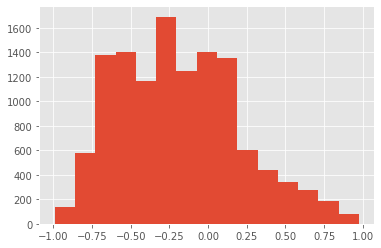

In [ ]:
img, label = cifar_dataset[0]
print("Label: ", label)
plt.hist(img[:, :, :].flatten(), bins=15)

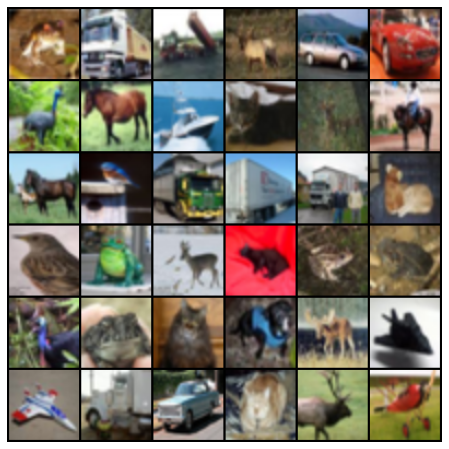

In [ ]:
# denormalization image from range (-1)-1 to range 0-1 to display it
def denorm(x):
    return (x + 1) / 2

# show image sample with matplotlib
to_show =[]
for i in range(36):
  to_show.append(cifar_dataset[i][0])

plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(make_grid(torch.stack(to_show), nrow=6, normalize=True).permute(1, 2, 0));

In [ ]:
# define the dataloader
data_loader = DataLoader(cifar_dataset, batch_size=CFG.batch_size, num_workers=CFG.workers, shuffle=True)

## Спектральная нормализация

In [ ]:
import torch
from torch.optim.optimizer import Optimizer, required

from torch.autograd import Variable
import torch.nn.functional as F
from torch import nn
from torch import Tensor
from torch.nn import Parameter

def l2normalize(v, eps=1e-12):
    return v / (v.norm() + eps)


class SpectralNorm(nn.Module):
    def __init__(self, module, name='weight', power_iterations=1):
        super(SpectralNorm, self).__init__()
        self.module = module
        self.name = name
        self.power_iterations = power_iterations
        if not self._made_params():
            self._make_params()

    def _update_u_v(self):
        u = getattr(self.module, self.name + "_u")
        v = getattr(self.module, self.name + "_v")
        w = getattr(self.module, self.name + "_bar")

        height = w.data.shape[0]
        for _ in range(self.power_iterations):
            v.data = l2normalize(torch.mv(torch.t(w.view(height,-1).data), u.data))
            u.data = l2normalize(torch.mv(w.view(height,-1).data, v.data))

        # sigma = torch.dot(u.data, torch.mv(w.view(height,-1).data, v.data))
        sigma = u.dot(w.view(height, -1).mv(v))
        setattr(self.module, self.name, w / sigma.expand_as(w))

    def _made_params(self):
        try:
            u = getattr(self.module, self.name + "_u")
            v = getattr(self.module, self.name + "_v")
            w = getattr(self.module, self.name + "_bar")
            return True
        except AttributeError:
            return False


    def _make_params(self):
        w = getattr(self.module, self.name)

        height = w.data.shape[0]
        width = w.view(height, -1).data.shape[1]

        u = Parameter(w.data.new(height).normal_(0, 1), requires_grad=False)
        v = Parameter(w.data.new(width).normal_(0, 1), requires_grad=False)
        u.data = l2normalize(u.data)
        v.data = l2normalize(v.data)
        w_bar = Parameter(w.data)

        del self.module._parameters[self.name]

        self.module.register_parameter(self.name + "_u", u)
        self.module.register_parameter(self.name + "_v", v)
        self.module.register_parameter(self.name + "_bar", w_bar)


    def forward(self, *args):
        self._update_u_v()
        return self.module.forward(*args)

## Tricks 
- use deeper CNN
- use LeakyRELU instead of ReLU
- use BatchNorm, Dropout
- SpectralNorm

In [ ]:
import torch.nn as nn

# Generator 
class Generator(nn.Module):
    def __init__(self, nc, nz, ngf):
        super(Generator, self).__init__()

        self.conv1 = nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False)
        self.batch1 = nn.BatchNorm2d(ngf * 8)
        
        self.conv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch2 = nn.BatchNorm2d(ngf * 4)
        
        self.conv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch3 = nn.BatchNorm2d(ngf * 2)

        self.conv4 = nn.ConvTranspose2d(ngf * 2, ngf, kernel_size=4, stride=2, padding=1, bias=False)
        self.batch4 = nn.BatchNorm2d(ngf)

        self.conv5 = nn.ConvTranspose2d(ngf, nc, kernel_size=4, stride=2, padding=1, bias=False)

    def forward(self, x):
        x = x.view((x.shape[0], x.shape[1], 1, 1))
        x = torch.relu(self.batch1(self.conv1(x)))
        x = torch.relu(self.batch2(self.conv2(x)))
        x = torch.relu(self.batch3(self.conv3(x)))
        x = torch.relu(self.batch4(self.conv4(x)))
        return torch.tanh(self.conv5(x))

# Discriminator 
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, with_spectral_norm):
        super(Discriminator, self).__init__()
        def conv2d(in_channels, out_channels, stride, padding):
          conv = nn.Conv2d(in_channels, out_channels, kernel_size=4, stride=stride, padding=padding, bias=False)
          if with_spectral_norm:
            return SpectralNorm(conv)
          else:
            return conv

        self.conv5 = conv2d(nc, ndf, stride=2, padding=1)
        self.dropout5 = nn.Dropout(0.25)

        self.conv4 = conv2d(ndf, ndf * 2, stride=2, padding=1)
        self.batch4 = nn.BatchNorm2d(ndf * 2)
        self.dropout4 = nn.Dropout(0.25)

        self.conv3 = conv2d(ndf * 2, ndf * 4, stride=2, padding=1)
        self.batch3 = nn.BatchNorm2d(ndf * 4)
        self.dropout3 = nn.Dropout(0.25)

        self.conv2 = conv2d(ndf * 4, ndf * 8, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(ndf * 8)
        self.dropout2 = nn.Dropout(0.25)

        self.conv1 = conv2d(ndf * 8, 1, stride=1, padding=0)

    def forward(self, x):
        x = self.dropout5(F.leaky_relu(self.conv5(x), 0.2))
        x = self.dropout4(F.leaky_relu(self.batch4(self.conv4(x)), 0.2))
        x = self.dropout3(F.leaky_relu(self.batch3(self.conv3(x)), 0.2))
        x = self.dropout2(F.leaky_relu(self.batch2(self.conv2(x)), 0.2))
        return torch.sigmoid(self.conv1(x))

Discriminator Training

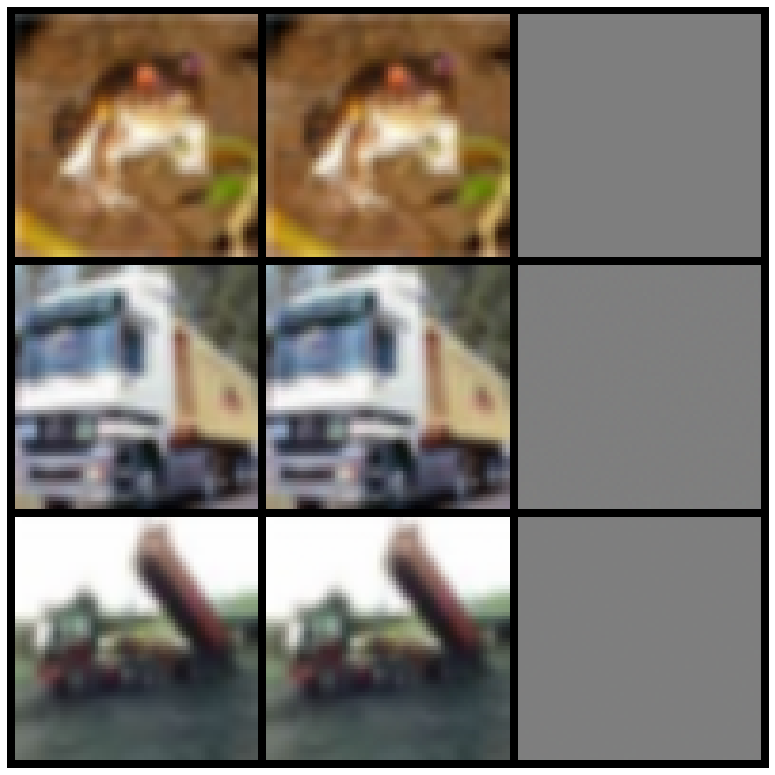

In [ ]:
# Add noise

def noise(z):
    noise_amp = 0.005 * np.random.uniform() * z.amax(dim=(2, 3))
    return z + noise_amp.view((z.shape[0], z.shape[1], 1, 1)) * torch.randn(z.shape).to(z.device)

to_show = []
for i in range(3):
  image = cifar_dataset[i][0]
  noised = noise(image.view(1, image.shape[0], image.shape[1], image.shape[2]))[0]
  to_show.append(image)
  to_show.append(noised)
  to_show.append(noised - image)

plt.figure(figsize=(14, 14))
plt.axis("off")
plt.imshow(make_grid(torch.stack(to_show), nrow=3, normalize=True).permute(1, 2, 0));

In [ ]:
criterion = nn.BCELoss()

def uniform_rand(batch_size, fr, to, device):
  return torch.FloatTensor(batch_size).uniform_(fr, to).to(device)

def train_discriminator(D_opt, D, G, images, latent_size, device, smooth_labels):
  
    # Create the labels which are later used as input for the BCE loss
    batch_size = images.shape[0]
    if smooth_labels:
      real_labels = uniform_rand(batch_size, 0.7, 0.9, device)
      fake_labels = uniform_rand(batch_size, 0.1, 0.3, device)
    else:
      real_labels = torch.ones(batch_size).to(device)
      fake_labels = torch.zeros(batch_size).to(device)

    D_opt.zero_grad()
    
    outputs = D(noise(images))
    # Loss for real images
    real_score = outputs.view(-1)
    real_loss = criterion(real_score, real_labels)
    real_loss.backward()

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z).detach()
    outputs = D(noise(fake_images))

    fake_score = outputs.view(-1)
    fake_loss = criterion(fake_score, fake_labels)
    fake_loss.backward()

    d_loss = real_loss + fake_loss
    D_opt.step()
    
    return d_loss, real_score, fake_score

Generator Training

In [ ]:
def train_generator(G_opt, D, G, batch_size, latent_size, device):
    # Generate fake images and calculate loss
    z = torch.Tensor(np.random.normal(0, 1, (batch_size, latent_size))).to(device)

    G_opt.zero_grad()

    fake_images = G(z)
    labels = torch.ones(batch_size).to(device)

    g_loss = criterion(D(noise(fake_images)).view(-1), labels)

    g_loss.backward()
    G_opt.step()

    return g_loss

## Start the training process

In [ ]:
# function to save the sample output of generator
sample_vectors = torch.randn(100, CFG.nz, 1, 1).to(CFG.device)

drive.mount('/content/drive')
def save_checkpoint(D, G, stat, index, model, sample_dir=CFG.sample_dir, batch_size=CFG.batch_size):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
    fake_fname = "fake_images-{0:0=4d}.png".format(index)
    print("Saving", fake_fname)
    save_image(
        denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10
    )

    snapshot_dir = f"/content/drive/My Drive/GAN_2022/{model}"
    if not os.path.exists(snapshot_dir):
      os.makedirs(snapshot_dir)
    torch.save(D.state_dict(), f"{snapshot_dir}/D{index}")
    torch.save(G.state_dict(), f"{snapshot_dir}/G{index}")

    shutil.make_archive("/content/images", "zip", "/content/images")
    shutil.copy("/content/images.zip", f"{snapshot_dir}/images.zip")
    with open(f"{snapshot_dir}/stat", 'wb') as f:
      pickle.dump(stat, f)


Mounted at /content/drive


In [ ]:
def train_model(D, G, model, d_losses, g_losses, real_scores, fake_scores, smooth_labels, st_from=0):
  G.to(CFG.device)
  D.to(CFG.device)
  g_opt = Adam(G.parameters(), CFG.lr, betas=CFG.betas)
  d_opt = Adam(D.parameters(), CFG.lr, betas=CFG.betas)

  total_step = len(data_loader)
  d_loss_acc = 0
  g_loss_acc = 0
  fake_score_acc = 0
  real_score_acc = 0
  acc_cnt = 0
  g_loss_acc_cnt = 0

  for epoch in range(st_from, CFG.num_epochs):
      for i, (images, _) in enumerate(data_loader):
          # Load a batch & transform to vectors
          images = images.to(CFG.device)

          if i % (CFG.g_steps + CFG.d_steps) < CFG.d_steps:
            # Train the discriminator
            d_loss, real_score, fake_score = train_discriminator(d_opt, D, G, images, latent_size=CFG.nz, device=CFG.device, smooth_labels=smooth_labels)
            d_loss_acc += d_loss.item()
            real_score_acc += real_score.mean().item()
            fake_score_acc += fake_score.mean().item()
            acc_cnt += 1
          else:
            # Train the generator
            g_loss = train_generator(g_opt, D, G, batch_size=CFG.batch_size, latent_size=CFG.nz, device=CFG.device)
            g_loss_acc += g_loss.item()
            g_loss_acc_cnt += 1

          # Inspect the losses
          if (i + 1) % 100 == 0 or (i + 1) == total_step:
              d_losses.append(d_loss_acc / acc_cnt)
              g_losses.append(g_loss_acc / g_loss_acc_cnt)
              real_scores.append(real_score_acc / acc_cnt)
              fake_scores.append(fake_score_acc / acc_cnt)
              print(
                  "Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}".format(
                      epoch + 1,
                      CFG.num_epochs,
                      i + 1,
                      total_step,
                      d_loss_acc / acc_cnt,
                      g_loss_acc / g_loss_acc_cnt,
                      real_score_acc / acc_cnt,
                      fake_score_acc / acc_cnt,
                  )
              )
              d_loss_acc = 0
              g_loss_acc = 0
              fake_score_acc = 0
              real_score_acc = 0
              acc_cnt = 0
              g_loss_acc_cnt = 0
      save_checkpoint(D, G, (d_losses, g_losses, real_scores, fake_scores), epoch + 1, model)

In [ ]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Train DCGAN

In [ ]:
%%time
G = Generator(CFG.nc, CFG.nz, CFG.ngf)
G.apply(weights_init)
print(G)

D = Discriminator(CFG.nc, CFG.ndf, with_spectral_norm=False)
D.apply(weights_init)
print(D)

d_losses, g_losses, real_scores, fake_scores = [], [], [], []

train_model(D, G, "DCGAN", d_losses, g_losses, real_scores, fake_scores, smooth_labels=False)    # d_steps=8;  g_steps = 10
# train_model(D, G, "DCGAN1", d_losses, g_losses, real_scores, fake_scores, smooth_labels=False) # d_steps=6;  g_steps = 10
# train_model(D, G, "DCGAN2", d_losses, g_losses, real_scores, fake_scores, smooth_labels=False) # d_steps=10; g_steps = 10
# train_model(D, G, "DCGAN3", d_losses, g_losses, real_scores, fake_scores, smooth_labels=False) # d_steps=5;  g_steps = 4

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv5): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (dropout5): Dropout(p=0.25, inp

## DCGAN result

In [ ]:
def load_stat(model):
  with open(f"/content/drive/My Drive/GAN_2022/{model}/stat", "rb") as f:
    return pickle.load(f)

def load_images(model):
  shutil.rmtree(f"{model}_images", ignore_errors=True)
  shutil.unpack_archive(f"/content/drive/My Drive/GAN_2022/{model}/images.zip", f"{model}_images")

In [ ]:
def plot_stat(groups):
  # show the discrimator loss and generator loss
  fig = plt.figure(figsize=(16, 6))
  cmap = plt.get_cmap('Set2')

  i = 0;
  for models in groups:
    i += 1
    ax = fig.add_subplot(1, 2, i)
    legend = []
    for (name, model) in models:
      _, _, real_scores, fake_scores = load_stat(model)
      steps = [i / 4 for i in range(len(real_scores))]
      ax.plot(steps, real_scores, "-")
      ax.plot(steps, fake_scores, "-")
      legend.append(f"{name} Real")
      legend.append(f"{name} Fake")
      ax.set_ylim(0, 1)

    ax.set_xlabel("epochs")
    ax.set_ylabel("score")
    ax.legend(legend)
    ax.set_title("Scores");

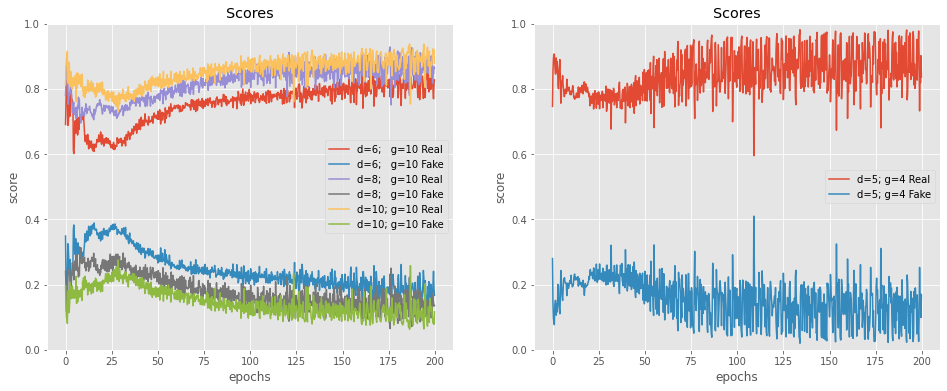

In [ ]:
plot_stat([
    [("d=6;   g=10", "DCGAN1"), ("d=8;   g=10", "DCGAN"), ("d=10; g=10", "DCGAN2")], 
    [("d=5; g=4", "DCGAN3")]
])

In [ ]:
def load_all_images(models):
  for model in tqdm(models):
    load_images(model)

load_all_images(["DCGAN", "DCGAN1", "DCGAN2", "DCGAN3"])

100%|██████████| 4/4 [00:17<00:00,  4.39s/it]


In [ ]:
def read_img(model, num):
  return mpimg.imread(os.path.join(f"{model}_images", "fake_images-{0:0=4d}.png".format(num)))

def plot_images(models):
  images = []
  for (label, model) in models:
    images.append((read_img(model, CFG.num_epochs), label))

  fig = plt.figure(figsize=(24, 24))
  i = 0
  for img, label in images:
    i += 1
    ax = fig.add_subplot(2, 2, i)
    ax.imshow(img)
    ax.set_title(label)
    ax.set_xticks([])
    ax.set_yticks([])

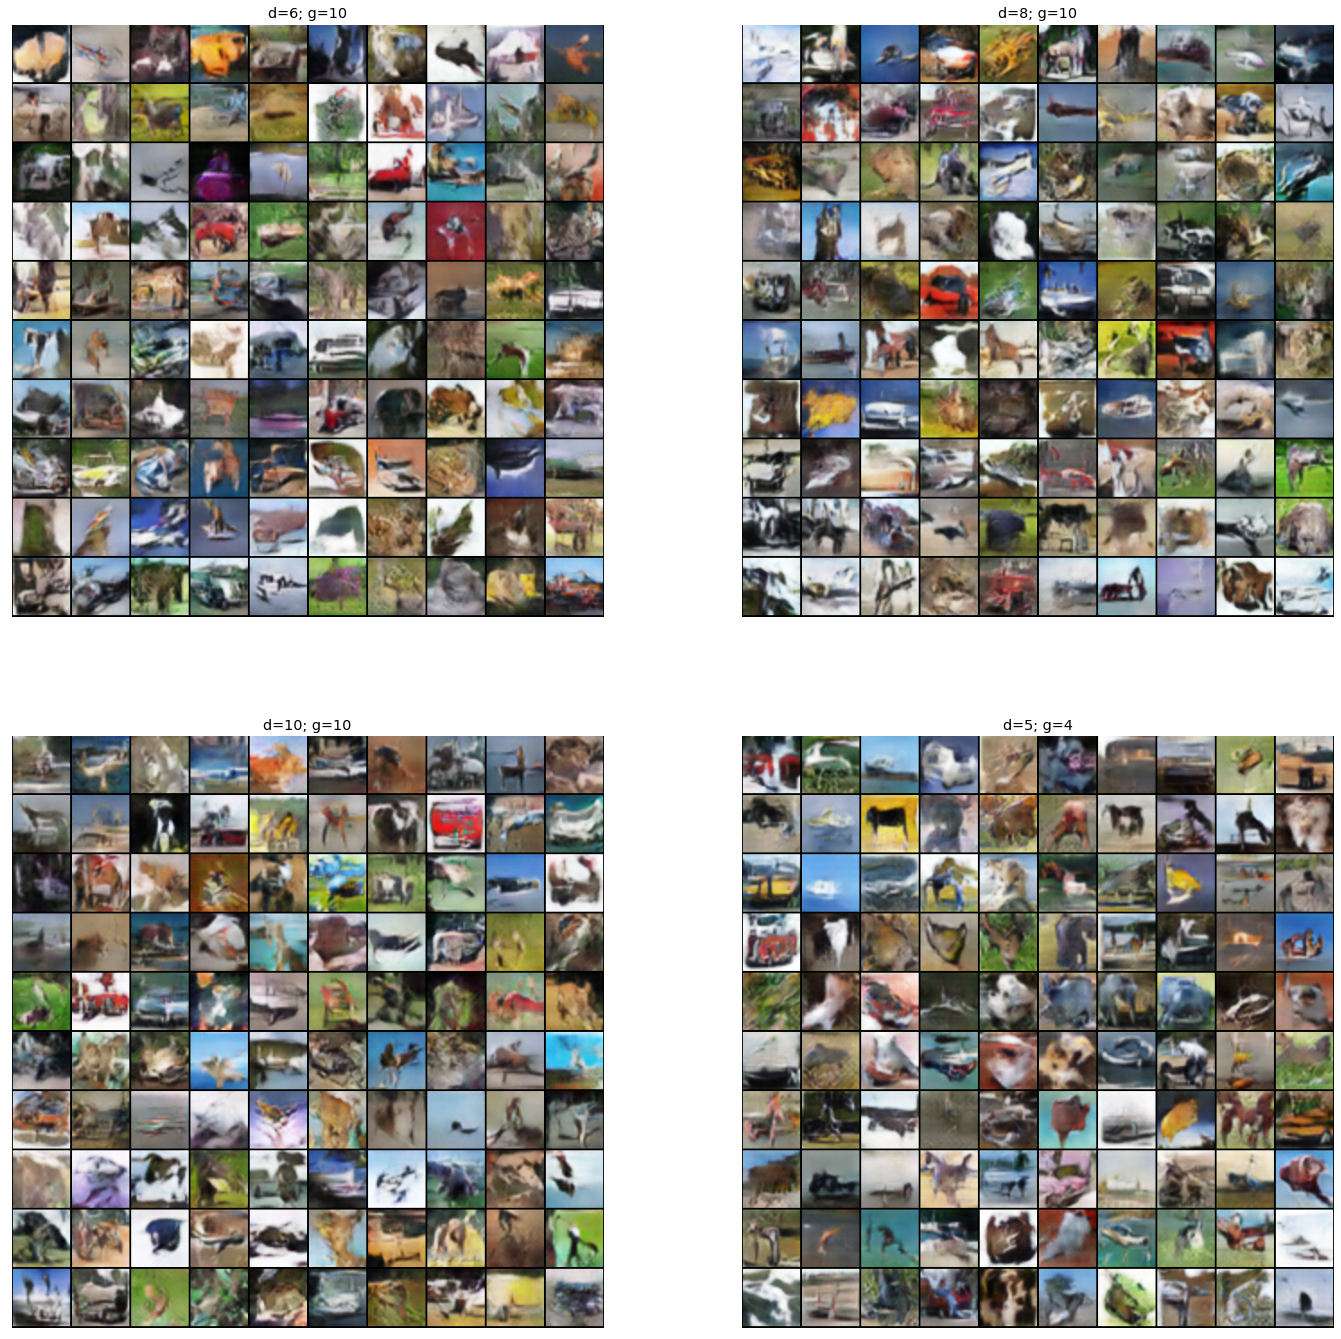

In [ ]:
plot_images([("d=6; g=10", "DCGAN1"), ("d=8; g=10", "DCGAN"), ("d=10; g=10", "DCGAN2"), ("d=5; g=4", "DCGAN3")])

## Metrics
Currently, this package supports following metrics:
- Inception Score (IS)
- Fréchet Inception Distance (FID)

In [ ]:
!git clone https://github.com/w86763777/pytorch-gan-metrics.git
!pip install pytorch-gan-metrics

Cloning into 'pytorch-gan-metrics'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 241 (delta 2), reused 2 (delta 0), pack-reused 230
Receiving objects: 100% (241/241), 61.51 KiB | 3.84 MiB/s, done.
Resolving deltas: 100% (135/135), done.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
def load_cifar_images(train):
  dataset = CIFAR10(CFG.dataroot, download=CFG.download, train=train)
  if train:
    ref_dir = f"{CFG.dataroot}/train"
  else:
    ref_dir = f"{CFG.dataroot}/test"

  os.makedirs(ref_dir, exist_ok=True)
  for i, (x, _) in tqdm(enumerate(dataset)):
    x.save(f"{ref_dir}/{i + 1}.png")

load_cifar_images(train=True)
load_cifar_images(train=False)

Files already downloaded and verified


50000it [00:32, 1535.15it/s]


Files already downloaded and verified


10000it [00:03, 3074.41it/s]


In [ ]:
!cd pytorch-gan-metrics
!python -m pytorch_gan_metrics.calc_fid_stats --path /content/data/train --output /content/statistics.npz

In [ ]:
from pytorch_gan_metrics import (get_inception_score,
                                 get_fid,
                                 get_inception_score_and_fid,
                                 get_inception_score_and_fid_from_directory)

def calc_cifar10_metrics():
  return get_inception_score_and_fid_from_directory(f"{CFG.dataroot}/test", "/content/statistics.npz")

cifar_metrics = calc_cifar10_metrics()

In [ ]:
class GeneratorDataset(Dataset):
    def __init__(self, G, len):
        self.G = G
        self.len = len
    
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return denorm(self.G(torch.randn(1, CFG.nz, 1, 1).to(CFG.device))[0])

def calc_model_metrics(model, cnt, epoch=CFG.num_epochs):
  G = Generator(CFG.nc, CFG.nz, CFG.ngf).to(CFG.device)
  G.load_state_dict(torch.load(f"/content/drive/My Drive/GAN_2022/{model}/G{epoch}"))
  dataset = GeneratorDataset(G, len=cnt)
  data_loader = DataLoader(dataset, batch_size=CFG.batch_size, num_workers=0)
  return get_inception_score_and_fid(data_loader, "/content/statistics.npz")

def calc_models_metrics(models, cnt, epoch=CFG.num_epochs, silent=False):
  metrics = []
  if silent:
    for model in models:
      metrics.append(calc_model_metrics(model, cnt, epoch=epoch))
  else:
    for model in tqdm(models):
      metrics.append(calc_model_metrics(model, cnt, epoch=epoch))
  return metrics

def to_df_with_cifar(metrics, names):
  rows = []
  for (IS, IS_std), FID in metrics + [cifar_metrics]:
    rows.append([f"{IS:.2f} ± {IS_std:.2f}", f"{FID:.2f}"])
  return pd.DataFrame(rows, index=names + ["CIFAR10"], columns=["IS", "FID"])

In [ ]:
metrics = calc_models_metrics(["DCGAN1", "DCGAN", "DCGAN2", "DCGAN3"], 10000)

In [ ]:
to_df_with_cifar(metrics, ["d=6; g=10", "d=8; g=10", "d=10; g=10", "d=5; g=4"])

IS     FID
d=6; g=10    3.06 ± 0.08  128.39
d=8; g=10    3.12 ± 0.06  126.84
d=10; g=10   2.96 ± 0.04  130.95
d=5; g=4     3.18 ± 0.09  126.94
CIFAR10     10.94 ± 0.15    3.15

Choose d=8;g=10 as a reference

# Train with regularization

In [ ]:
# DCGAN + LS
%%time
G = Generator(CFG.nc, CFG.nz, CFG.ngf)
G.apply(weights_init)
print(G)

D = Discriminator(CFG.nc, CFG.ndf, with_spectral_norm=False)
D.apply(weights_init)
print(D)

d_losses, g_losses, real_scores, fake_scores = [], [], [], []
train_model(D, G, "LS", d_losses, g_losses, real_scores, fake_scores, smooth_labels=True)

Generator(
  (conv1): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
  (batch1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (batch4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
)
Discriminator(
  (conv5): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (dropout5): Dropout(p=0.25, inp

In [ ]:
# DCGAN + SN
%%time
G = Generator(CFG.nc, CFG.nz, CFG.ngf)
G.apply(weights_init)
print(G)

D = Discriminator(CFG.nc, CFG.ndf, with_spectral_norm=True)
print(D)

d_losses, g_losses, real_scores, fake_scores = [], [], [], []
train_model(D, G, "SN", d_losses, g_losses, real_scores, fake_scores, smooth_labels=False)

In [ ]:
# DCGAN + LS + SN
%%time
G = Generator(CFG.nc, CFG.nz, CFG.ngf)
G.apply(weights_init)
print(G)

D = Discriminator(CFG.nc, CFG.ndf, with_spectral_norm=True)
print(D)

d_losses, g_losses, real_scores, fake_scores = [], [], [], []
train_model(D, G, "LS_SN", d_losses, g_losses, real_scores, fake_scores, smooth_labels=True)

## Regulatization results

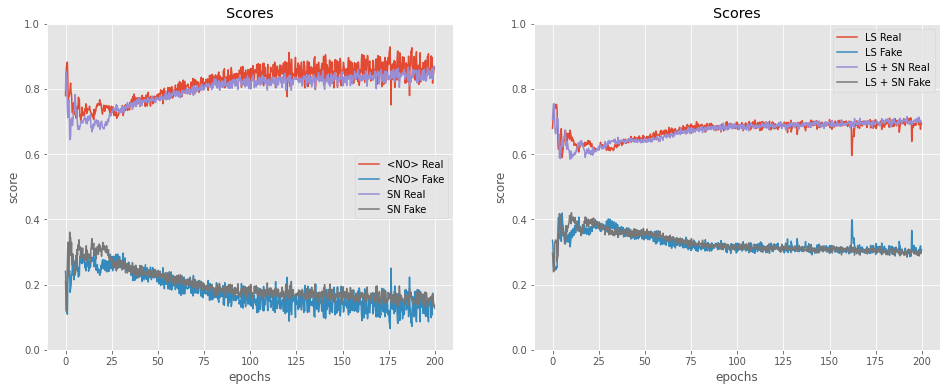

In [ ]:
plot_stat([
    [("<NO>", "DCGAN"), ("SN", "SN")],
    [("LS", "LS"), ("LS + SN", "LS_SN")]
])

In [ ]:
models = ["DCGAN", "SN", "LS", "LS_SN"]
load_all_images(models)

100%|██████████| 4/4 [00:15<00:00,  3.97s/it]


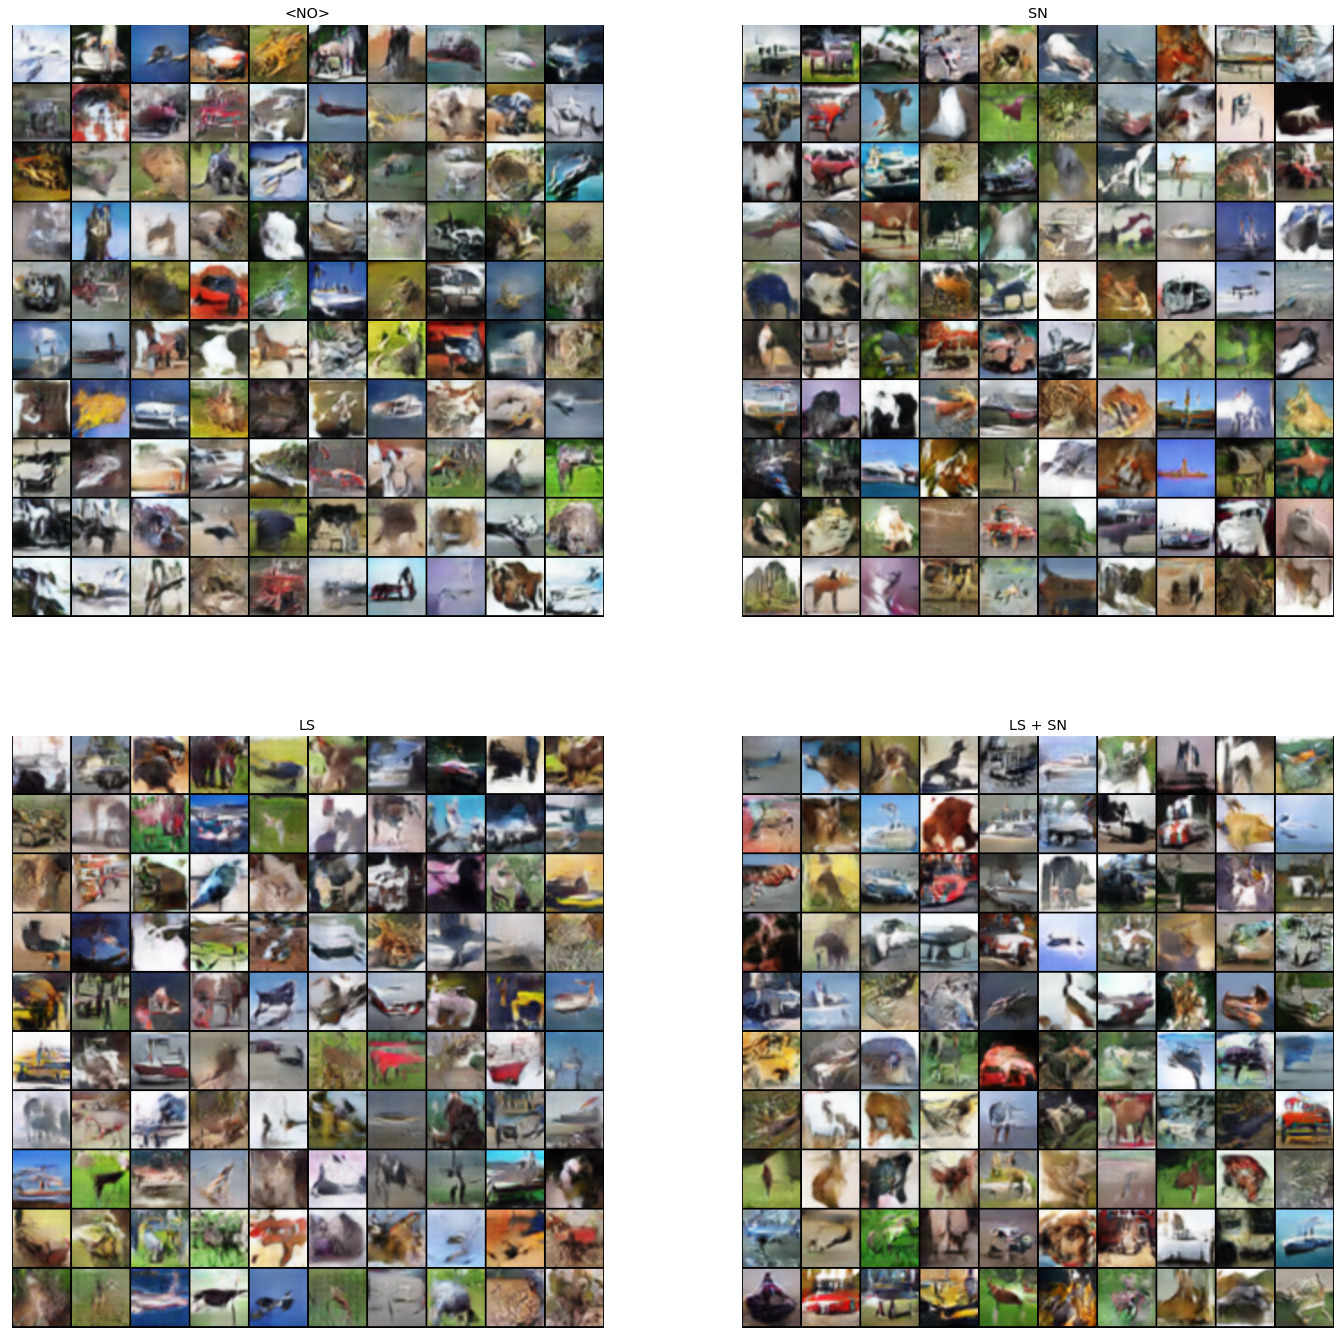

In [ ]:
plot_images([("<NO>", "DCGAN"), ("SN", "SN"), ("LS", "LS"), ("LS + SN", "LS_SN")])

## Metrics

In [ ]:
metrics = calc_models_metrics(models, 10000)

100%|██████████| 4/4 [03:41<00:00, 55.34s/it]


In [ ]:
to_df_with_cifar(metrics, models)

IS     FID
DCGAN     3.09 ± 0.06  126.12
SN        2.77 ± 0.05  137.13
LS        3.08 ± 0.07  127.77
LS + SN   3.09 ± 0.06  130.95
CIFAR10  10.94 ± 0.15    3.15

In [ ]:
IS = [[] for _ in range(len(models))]
FID = [[] for _ in range(len(models))]

for i in tqdm(range(5, 201, 5)):
  metrics = calc_models_metrics(models, 10000, epoch=i, silent=True)

  for j in range(4):
    IS[j].append(metrics[j][0][0])
    FID[j].append(metrics[j][1])

  with open(f"/content/drive/My Drive/GAN_2022/metrics", 'wb') as f:
    pickle.dump((IS, FID), f)

100%|██████████| 40/40 [2:29:09<00:00, 223.73s/it]


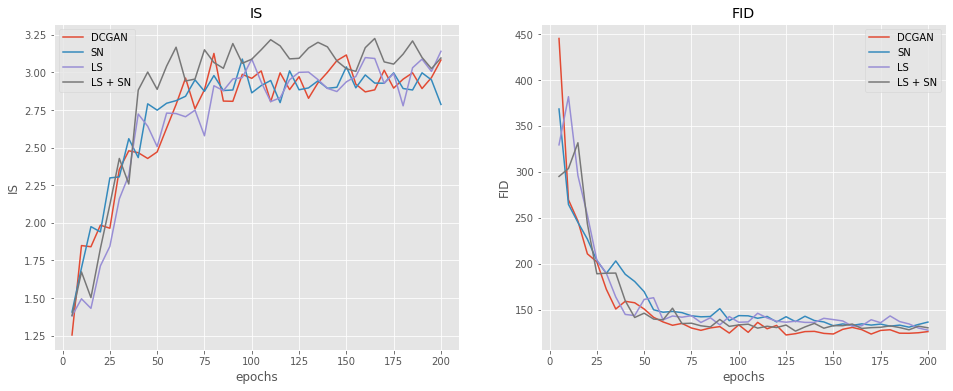

In [ ]:
fig = plt.figure(figsize=(16, 6))
steps = list(range(5, 201, 5))

ax = fig.add_subplot(1, 2, 1)
for j in range(len(IS)):
  ax.plot(steps, IS[j], "-")
ax.set_xlabel("epochs")
ax.set_ylabel("IS")
ax.legend(models)
ax.set_title("IS")

ax = fig.add_subplot(1, 2, 2)
for j in range(len(FID)):
  ax.plot(steps, FID[j], "-")
ax.set_xlabel("epochs")
ax.set_ylabel("FID")
ax.legend(models)
ax.set_title("FID");

In [ ]:
metrics = calc_models_metrics(models, 10000, epoch=180)
to_df_with_cifar(metrics, models)

100%|██████████| 4/4 [04:04<00:00, 61.11s/it]


IS     FID
DCGAN     2.96 ± 0.04  127.84
SN        2.92 ± 0.05  131.98
LS        2.80 ± 0.03  142.90
LS_SN     3.15 ± 0.06  130.96
CIFAR10  10.94 ± 0.15    3.15